In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [ ]:
fm = matplotlib.font_manager.fontManager
fm.addfont("./仿宋_GB2312.TTF")
fm.addfont("./STSONG.TTF")
fm.addfont("./times.ttf")
fm.addfont("./timesbd.ttf")
fm.addfont("./timesbi.ttf")
fm.addfont("./timesi.ttf")

# 设置中文字体和负号正常显示,启用LaTeX排版
plt.rcParams["font.sans-serif"] = ["FangSong_GB2312", "STSONG"]
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams['text.usetex'] = True
'''
总结：只需用 $...$ 包裹公式，并使用原始字符串 r''，即可在 matplotlib 中轻松使用 LaTeX 公式。
'''


In [139]:
def set_fig(
    figsize:tuple,
    is_grid = False,     # 是否显示网格线
    x_lable = "X",      # X轴标题
    y_lable = "Y",      # Y轴标题
    x_range_l = -20,    # x左
    x_range_r = 20,     # x右
    y_range_l = -20,    # y左
    y_range_r = 20,     # y右
):
    plt.xlim([x_range_l, x_range_r])
    plt.ylim([y_range_l, y_range_r])
    plt.xlabel(x_lable)
    plt.ylabel(y_lable)
    plt.figure(figsize=figsize)
    plt.grid(is_grid)
    

In [140]:
def line(
    Point1: np.ndarray, # 点1坐标
    Point2: np.ndarray, # 点2坐标
    points=10,          # 中间点数量（控制线条精细度）
    line_width = 1,     # 线宽
    Color="blue",       # 线色
    line_lable = "线1", # 图例名
    
    is_legend = True,   # 是否显示图例
):
    if Point1[0] == Point2[0]:
        Xs = np.full((points),Point1[1])
    else:
        Xs = np.arange(Point1[0], Point2[0], (Point2[0] - Point1[0]) / points)

    if Point1[1] == Point2[1]:
        Ys = np.full((points),Point1[1])
    else:
        Ys = np.arange(Point1[1], Point2[1], (Point2[1] - Point1[1]) / points)
    plt.plot(Xs, Ys,linewidth= line_width,color=Color,label=line_lable)
    
    if is_legend:
        plt.legend(loc="upper right")


In [159]:

    
    
    
    # if is_legend:
    #     plt.legend(loc="upper right")

    # pass

In [160]:
# plt.figure(figsize=(8,8))
# line(np.array([0,0]),np.array([10,5]))
# line(np.array([0,5]),np.array([10,10]),line_width=3,is_grid=True,is_legend=False)
# plt.show()


In [143]:
# Point1,Point2 = np.array([0,15]),np.array([-10,15])
# points=100
# Color="#FFF000"
# line_lable = "线1"
# x_lable = "x标题"
# y_lable = "y标题"
# x_range_l = -20
# x_range_r = 20
# y_range_l = -20
# y_range_r = 20
# title = "图标题"

# if Point1[0] == Point2[0]:
#     Xs = np.full((points),Point1[1])
# else:
#     Xs = np.arange(Point1[0], Point2[0], (Point2[0] - Point1[0]) / points)

# if Point1[1] == Point2[1]:
#     Ys = np.full((points),Point1[1])
# else:
#     Ys = np.arange(Point1[1], Point2[1], (Point2[1] - Point1[1]) / points)
# plt.plot(Xs, Ys, color=Color,label=line_lable)
# plt.xlim([x_range_l, x_range_r])
# plt.ylim([y_range_l, y_range_r])
# plt.xlabel(x_lable)
# plt.ylabel(y_lable)
# plt.title(title)
# plt.legend()
# # plt.grid(True) # 网格显示


In [ ]:
def circle(
    center,
    radius,
    line_width = 1,     # 线宽
    color="red",       # 线色
    line_lable = "线1", # 图例名
    is_legend = True,   # 是否显示图例
    is_fill = False      # 是否填充
    ):
    fig, ax = plt.subplots(figsize=(6, 6))
    circle = plt.Circle(center, radius=radius, color=color, fill=is_fill, linewidth=line_width,label="yuan")
    ax.add_patch(circle)
    

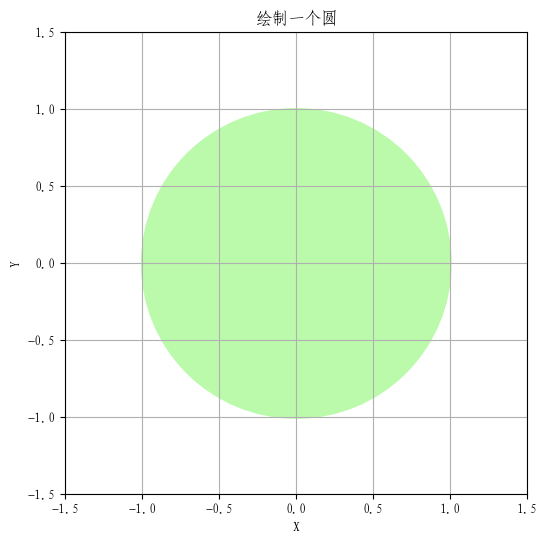

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))

# 创建一个圆：(x, y) 是圆心，r 是半径
circle = plt.Circle((0, 0), radius=1, color='#BBFAAB', fill=True, linewidth=2,label="yuan")

# 将圆添加到 axes 中
ax.add_patch(circle)

# 设置坐标轴范围
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

# 保持比例一致，否则圆看起来像椭圆
ax.set_aspect('equal')

# 添加网格、标题
ax.grid(True)
plt.title("绘制一个圆")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

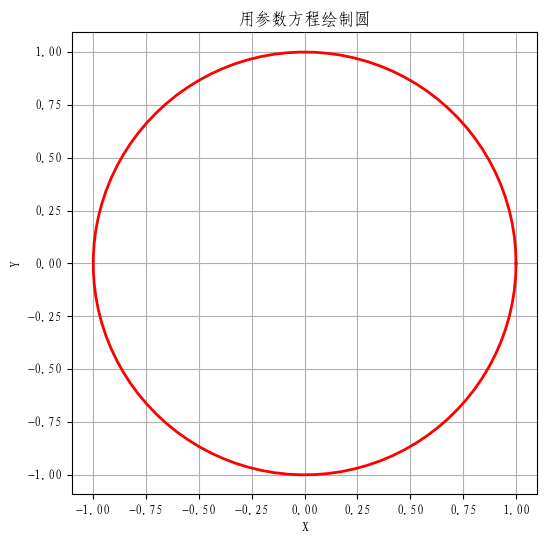

In [145]:
import matplotlib.pyplot as plt
import numpy as np

theta = np.linspace(0, 2 * np.pi, 100)
x = np.cos(theta)  # 半径为 1
y = np.sin(theta)

plt.figure(figsize=(6, 6))
plt.plot(x, y, color='red', linewidth=2)
plt.axis('equal')  # 保持等比例
plt.grid(True)
plt.title("用参数方程绘制圆")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

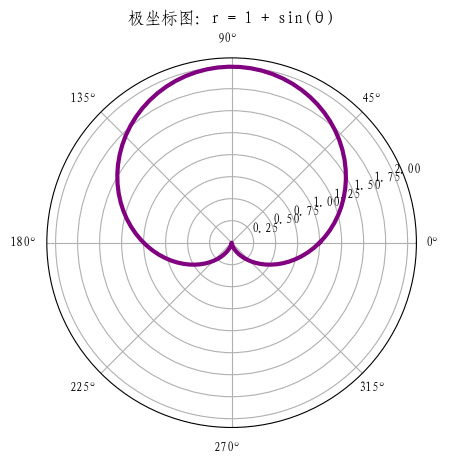

In [146]:
import matplotlib.pyplot as plt
import numpy as np

# 角度 theta: 0 到 2π
theta = np.linspace(0, 2 * np.pi, 100)

# 极径 r（可以是任意函数）
r = 1 + np.sin(theta)  # 心形线（cardioid）

# 创建极坐标图
ax = plt.subplot(111, projection='polar')
ax.plot(theta, r, color='purple', linewidth=3)

ax.set_title("极坐标图：r = 1 + sin(θ)")
plt.show()

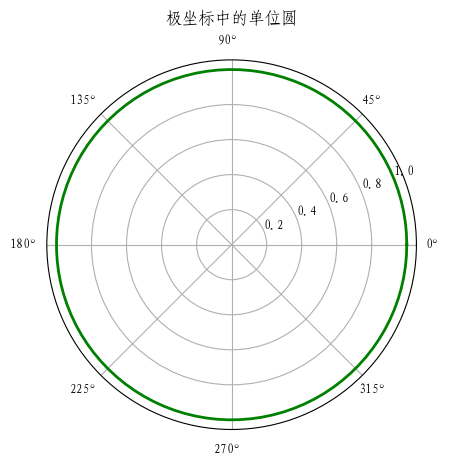

In [147]:
import matplotlib.pyplot as plt
import numpy as np

theta = np.linspace(0, 2 * np.pi, 100)
r = np.ones_like(theta)  # 所有点的极径都是 1

ax = plt.subplot(111, projection='polar')
ax.plot(theta, r, color='green', linewidth=2)
ax.set_title("极坐标中的单位圆", va='bottom')
plt.show()

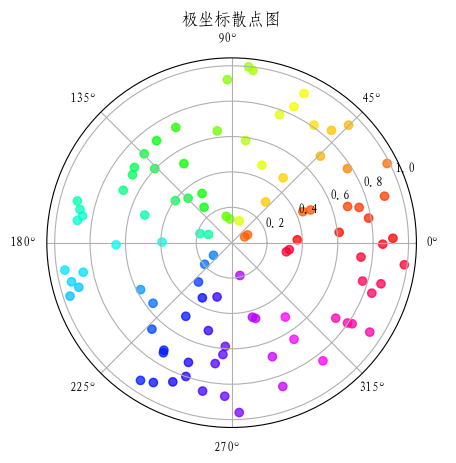

In [148]:
import matplotlib.pyplot as plt
import numpy as np

# 随机角度和半径
theta = 2 * np.pi * np.random.rand(100)
r = np.sqrt(np.random.rand(100))  # 开根号使分布更均匀

ax = plt.subplot(111, projection='polar')
ax.scatter(theta, r, c=theta, cmap='hsv', alpha=0.75)
ax.set_title("极坐标散点图")
plt.show()

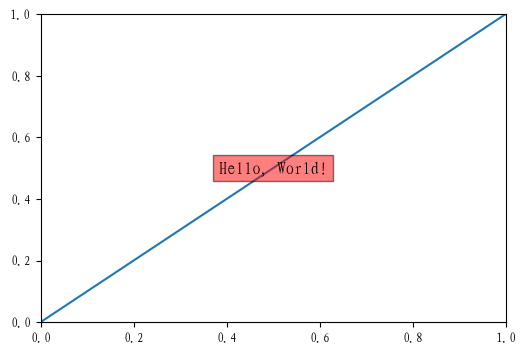

In [149]:
import matplotlib.pyplot as plt

# 创建一个示例图
plt.figure(figsize=(6, 4))
plt.plot([0, 1], [0, 1])  # 示例数据线

# 添加文本
plt.text(0.5, 0.5, 'Hello, World!', fontsize=12, ha='center', va='center',
         bbox=dict(facecolor='red', alpha=0.5))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

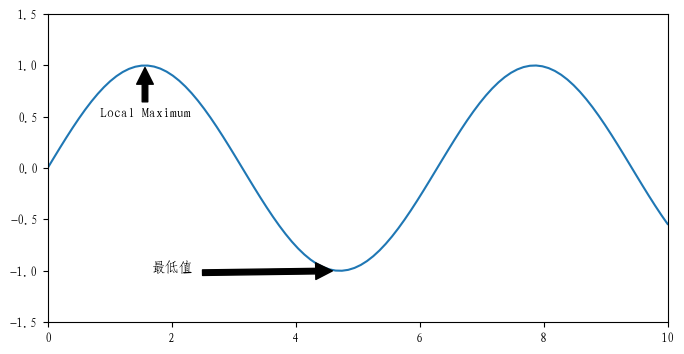

In [150]:
import matplotlib.pyplot as plt
import numpy as np

# 创建数据
x = np.linspace(0, 10, 100)
y = np.sin(x)

plt.figure(figsize=(8, 4))
plt.plot(x, y)

# 添加注释
plt.annotate('Local Maximum', xy=(np.pi/2, 1), xytext=(np.pi/2, 0.5),
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center')
plt.annotate('最低值', xy=(np.pi*3/2, -1), xytext=(2, -1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center')

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5)
plt.show()

Text(0.5, 0.5, 'Rotated Text')

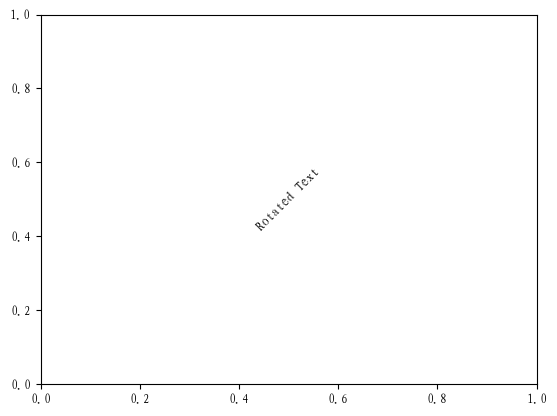

In [151]:
plt.text(0.5, 0.5, 'Rotated Text', rotation=45, ha='center', va='center')

Text(0.5, 0.5, 'Styled Text')

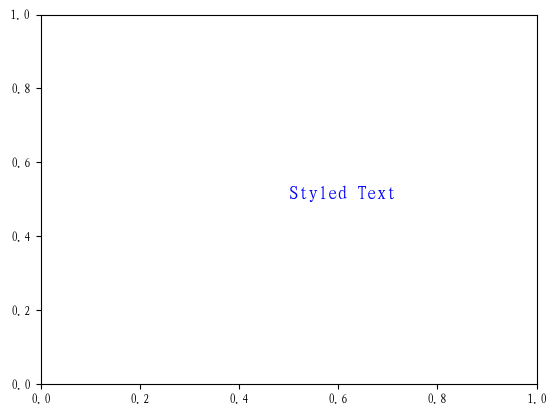

In [152]:
plt.text(0.5, 0.5, 'Styled Text', color='blue', fontweight='bold', fontsize=14)

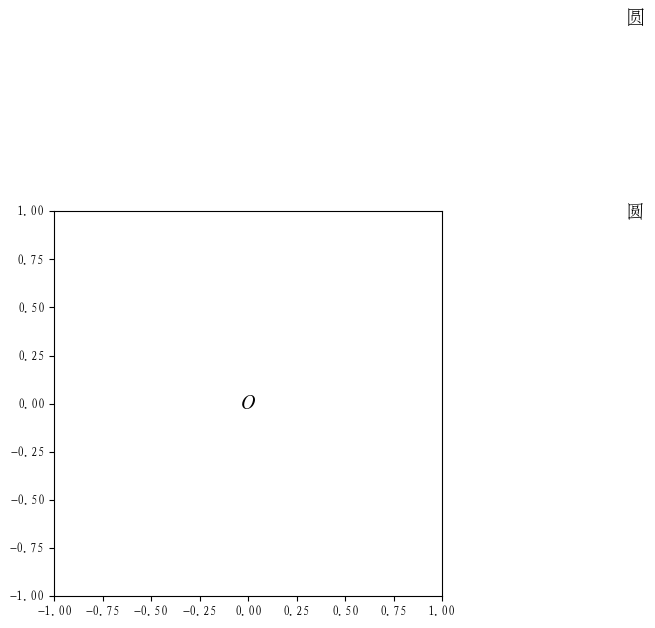

In [158]:
import matplotlib.pyplot as plt

# 创建一个新的图形
plt.figure(figsize=(5, 5))

# 在(0, 0)位置添加文本'O'
plt.text(0, 0, 'O', fontsize=14, fontname='Times New Roman', 
         style='italic', ha='center', va='center')
plt.text(2, 2, '圆', fontsize=14, fontname='STSONG', 
          ha='center', va='center')
plt.text(2, 1, '圆', fontsize=14, fontname='FangSong_GB2312', 
          ha='center', va='center')
# 设置坐标轴范围使文本居中显示
plt.xlim(-1, 1)
plt.ylim(-1, 1)

# 可选：移除坐标轴以获得更清晰的视图
# plt.axis('off')

# 显示图表
plt.show()

In [155]:
# fm.ttflist